# Small-World Network Epidemic Dynamics with Adaptive Rewiring: A Development of the SIS Model

Running simulation for adaptive rewiring rate: 0...
Done.
Running simulation for adaptive rewiring rate: 0.2...
Done.
Running simulation for adaptive rewiring rate: 0.5...
Done.
Running simulation for adaptive rewiring rate: 0.8...
Done.

Generating Figure 1...
Saved plot to: figure_1_temporal_dynamics.png


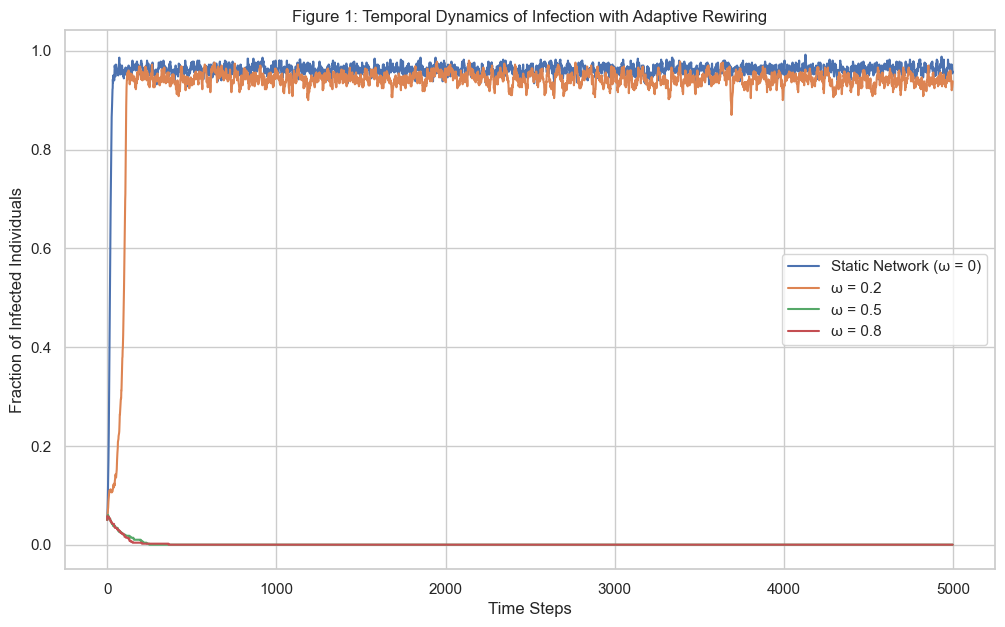


Generating Figure 2...
Saved plot to: figure_2_quantitative_metrics.png


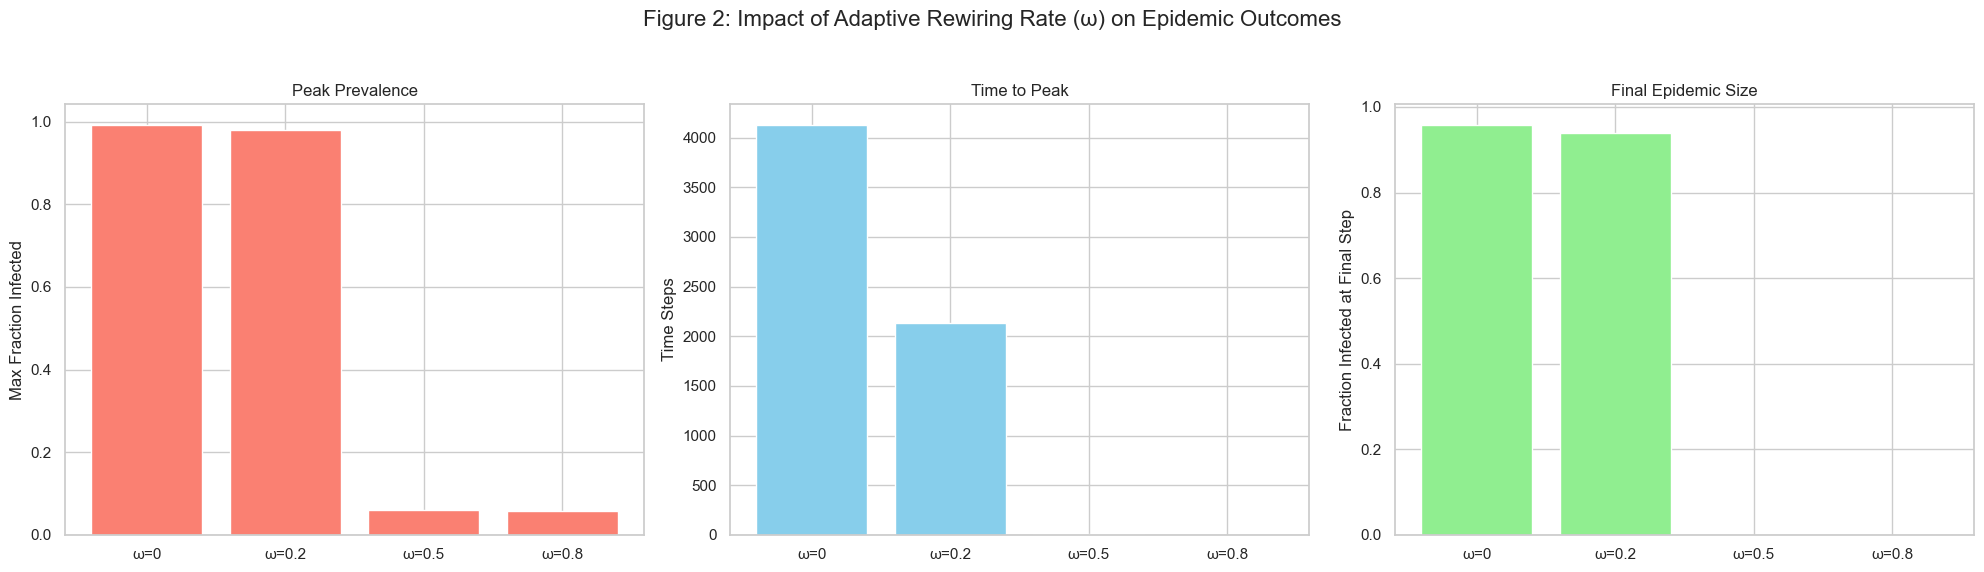


Generating example network visualizations...
Saved network graph to: network_visualization_static_network_(example_state).png


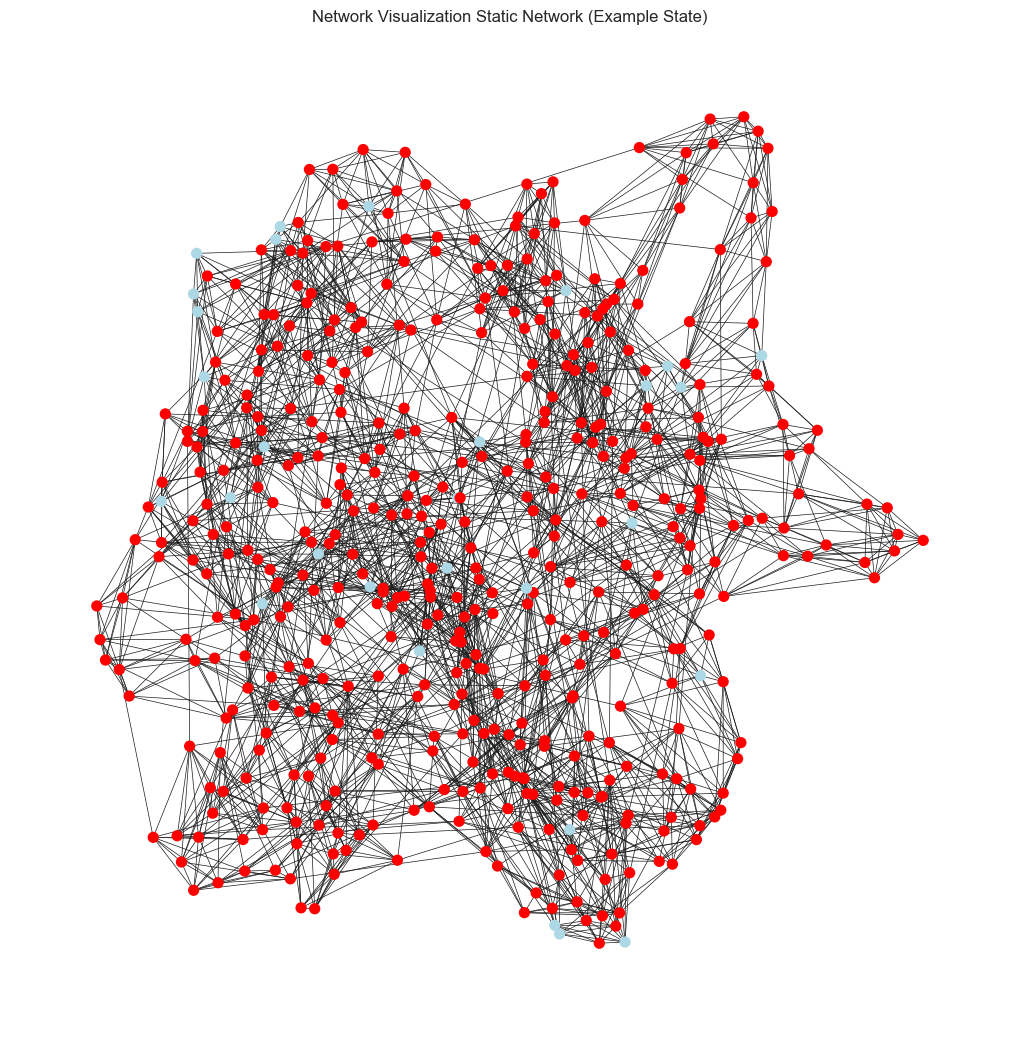

Saved network graph to: network_visualization_adaptive_network_ω=0.8_(example_state).png


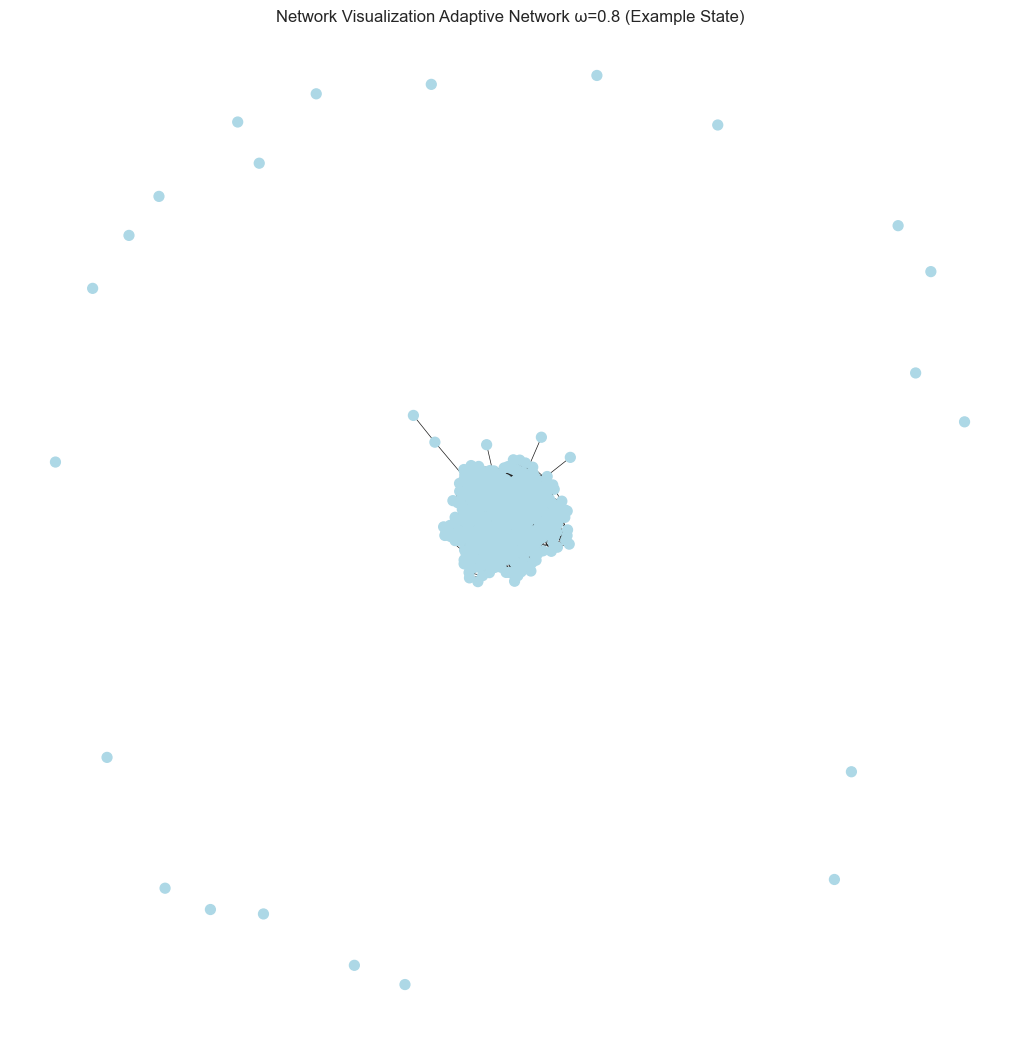


All tasks complete.


In [18]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import os

def run_sis_simulation(network_size, avg_degree, sw_prob, infection_prob, recovery_prob, adaptive_rewiring_rate, initial_infected_fraction, steps):
    """
    Runs a single SIS simulation on a Watts-Strogatz small-world network.
    """
    # 1. Initialize the network
    G = nx.watts_strogatz_graph(n=network_size, k=avg_degree, p=sw_prob)

    # 2. Initialize node states (S or I)
    for node in G.nodes():
        G.nodes[node]['state'] = 'S'

    # 3. Set initial infected nodes
    num_initial_infected = int(initial_infected_fraction * network_size)
    initial_infected_nodes = random.sample(list(G.nodes()), num_initial_infected)
    for node in initial_infected_nodes:
        G.nodes[node]['state'] = 'I'

    # 4. Simulation loop
    infected_fraction_over_time = []
    for _ in range(steps):
        # Store current infected fraction
        infected_count = [node for node, data in G.nodes(data=True) if data['state'] == 'I'].__len__()
        infected_fraction_over_time.append(infected_count / network_size)

        # Get current states for processing
        current_states = nx.get_node_attributes(G, 'state')
        nodes_to_update = {}

        # a. Adaptive Rewiring
        if adaptive_rewiring_rate > 0:
            for u in list(G.nodes()):
                if current_states[u] == 'S':
                    infected_neighbors = [v for v in G.neighbors(u) if current_states[v] == 'I']
                    for v_infected in infected_neighbors:
                        if random.random() < adaptive_rewiring_rate:
                            G.remove_edge(u, v_infected)
                            susceptible_nodes = [n for n, d in G.nodes(data=True) if d['state'] == 'S' and n != u and not G.has_edge(u, n)]
                            if susceptible_nodes:
                                new_neighbor = random.choice(susceptible_nodes)
                                G.add_edge(u, new_neighbor)

        # b. Infection and Recovery Dynamics
        for node in G.nodes():
            if current_states[node] == 'S':
                infected_neighbors = [neighbor for neighbor in G.neighbors(node) if current_states[neighbor] == 'I']
                if infected_neighbors:
                    prob_no_infection = (1 - infection_prob) ** len(infected_neighbors)
                    if random.random() > prob_no_infection:
                        nodes_to_update[node] = 'I'
            elif current_states[node] == 'I':
                if random.random() < recovery_prob:
                    nodes_to_update[node] = 'S'

        # Update node states after iterating
        for node, new_state in nodes_to_update.items():
            G.nodes[node]['state'] = new_state

    return infected_fraction_over_time, G

def draw_network(G, title):
    """
    Draws and saves a network visualization.
    """
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, iterations=50)
    node_colors = ['red' if G.nodes[n]['state'] == 'I' else 'lightblue' for n in G.nodes()]
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, width=0.5)
    plt.title(title)
    
    # Create a simple filename from the title and save the figure
    filename = title.lower().replace(' ', '_').replace(':', '') + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved network graph to: {filename}")
    
    plt.show()

def main():
    """
    Main function to run simulations and plot results as described in the report.
    """
    # --- Simulation Parameters ---
    NETWORK_SIZE = 500
    AVG_DEGREE = 10
    SW_PROB = 0.1
    INFECTION_PROB = 0.03
    RECOVERY_PROB = 0.01
    SIMULATION_STEPS = 5000
    INITIAL_INFECTED_FRACTION = 0.05
    ADAPTIVE_REWIRING_RATES = [0, 0.2, 0.5, 0.8]

    # --- Run Simulations ---
    results = {}
    for rate in ADAPTIVE_REWIRING_RATES:
        print(f"Running simulation for adaptive rewiring rate: {rate}...")
        infected_over_time, _ = run_sis_simulation(
            network_size=NETWORK_SIZE, avg_degree=AVG_DEGREE, sw_prob=SW_PROB,
            infection_prob=INFECTION_PROB, recovery_prob=RECOVERY_PROB,
            adaptive_rewiring_rate=rate, initial_infected_fraction=INITIAL_INFECTED_FRACTION,
            steps=SIMULATION_STEPS
        )
        results[rate] = infected_over_time
        print("Done.")

    # --- Figure 1: Temporal Dynamics Plot ---
    print("\nGenerating Figure 1...")
    plt.figure(figsize=(12, 7))
    for rate, infected_fractions in results.items():
        label = f"ω = {rate}" if rate > 0 else "Static Network (ω = 0)"
        plt.plot(infected_fractions, label=label)

    plt.title('Figure 1: Temporal Dynamics of Infection with Adaptive Rewiring')
    plt.xlabel('Time Steps')
    plt.ylabel('Fraction of Infected Individuals')
    plt.legend()
    plt.grid(True)
    plt.savefig('figure_1_temporal_dynamics.png', dpi=300) # Saves the plot
    print("Saved plot to: figure_1_temporal_dynamics.png")
    plt.show()

    # --- Calculate Metrics for Figure 2 ---
    peak_prevalence = {r: max(res) for r, res in results.items()}
    time_to_peak = {r: np.argmax(res) for r, res in results.items()}
    final_epidemic_size = {r: res[-1] for r, res in results.items()}

    # --- Figure 2: Bar Charts for Metrics ---
    print("\nGenerating Figure 2...")
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Figure 2: Impact of Adaptive Rewiring Rate (ω) on Epidemic Outcomes', fontsize=16)

    axes[0].bar(range(len(ADAPTIVE_REWIRING_RATES)), peak_prevalence.values(), color='salmon')
    axes[0].set_title('Peak Prevalence')
    axes[0].set_ylabel('Max Fraction Infected')
    axes[0].set_xticks(range(len(ADAPTIVE_REWIRING_RATES)))
    axes[0].set_xticklabels([f"ω={r}" for r in ADAPTIVE_REWIRING_RATES])

    axes[1].bar(range(len(ADAPTIVE_REWIRING_RATES)), time_to_peak.values(), color='skyblue')
    axes[1].set_title('Time to Peak')
    axes[1].set_ylabel('Time Steps')
    axes[1].set_xticks(range(len(ADAPTIVE_REWIRING_RATES)))
    axes[1].set_xticklabels([f"ω={r}" for r in ADAPTIVE_REWIRING_RATES])

    axes[2].bar(range(len(ADAPTIVE_REWIRING_RATES)), final_epidemic_size.values(), color='lightgreen')
    axes[2].set_title('Final Epidemic Size')
    axes[2].set_ylabel('Fraction Infected at Final Step')
    axes[2].set_xticks(range(len(ADAPTIVE_REWIRING_RATES)))
    axes[2].set_xticklabels([f"ω={r}" for r in ADAPTIVE_REWIRING_RATES])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('figure_2_quantitative_metrics.png', dpi=300) # Saves the plot
    print("Saved plot to: figure_2_quantitative_metrics.png")
    plt.show()

    # --- Network Visualization Examples ---
    print("\nGenerating example network visualizations...")
    _, G_static = run_sis_simulation(NETWORK_SIZE, AVG_DEGREE, SW_PROB, INFECTION_PROB, RECOVERY_PROB, 0, INITIAL_INFECTED_FRACTION, 500)
    _, G_adaptive = run_sis_simulation(NETWORK_SIZE, AVG_DEGREE, SW_PROB, INFECTION_PROB, RECOVERY_PROB, 0.8, INITIAL_INFECTED_FRACTION, 500)

    draw_network(G_static, 'Network Visualization Static Network (Example State)')
    draw_network(G_adaptive, 'Network Visualization Adaptive Network ω=0.8 (Example State)')
    
    print("\nAll tasks complete.")

if __name__ == '__main__':
    main()